# Comparison of MHMCMC and NUTS for Multivariate Gaussian and Ring

In [2]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.style.use('seaborn')
sns.set_context("poster",font_scale=1)
%matplotlib inline

## 50 dimensional, highly correlated Gaussian

Creating the data for the background distribution image.

In [3]:
N = 1000000
ndim= 50
try:
    with open("50dim0.7covar1000000.pkl", "rb") as f:
        background_y = pickle.load(f)
except:
    mv_model = pm.Model()
    cov = np.identity(ndim)
    mu = np.zeros(ndim)
    np.place(cov, cov==0, 0.7)
    with mv_model:
        y = pm.MvNormal('y', mu=mu, cov=cov, shape=(1,ndim))
        #step = pm.Metropolis()
        trace = pm.sample(N)
    #pm.traceplot(trace)
    background_y = trace.get_values("y")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y]
  4%|▎         | 36269/1000500 [57:02<41:58:50,  6.38it/s] /usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "<ipython-input-3-2b29250d7ff0>", line 4, in <module>
    with open("50dim0.7covar1000000.pkl", "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: '50dim0.7covar1000000.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:452: UserWa

KeyboardInterrupt: 

In [3]:
background_y = background_y.reshape(N, ndim)

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
background_y = pca.fit_transform(background_y)

Sampling from the distribution

In [5]:
sample_N = 500
cov = np.identity(ndim)
mu = np.zeros(ndim)
np.place(cov, cov==0, 0.7)

metr_mv_model = pm.Model()
nuts_mv_model = pm.Model()

with metr_mv_model:
    y = pm.MvNormal('y', mu=mu, cov=cov, shape=(ndim))
    step = pm.Metropolis(vars=[y])
    trace = pm.sample(sample_N/2, step=step, tune=1000)
metr_y = trace.get_values("y")
metr_y = metr_y.reshape(sample_N, ndim)
metr_y = pca.transform(metr_y)

with nuts_mv_model:
    y = pm.MvNormal('y', mu=mu, cov=cov, shape=(ndim))
    step = pm.NUTS(vars=[y])
    trace = pm.sample(sample_N/2, step=step, tune=1000)
nuts_y = trace.get_values("y")
nuts_y = nuts_y.reshape(sample_N, ndim)
nuts_y = pca.transform(nuts_y)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [y]
100%|██████████| 1250/1250.0 [00:00<00:00, 1709.67it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y]
 99%|█████████▊| 1233/1250.0 [00:11<00:00, 235.84it/s]/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:430: UserWarning: Chain 0 contains only 250 samples.
  % (self._chain_id, n))
100%|██████████| 1250/1250.0 [00:11<00:00, 112.72it/s]
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:430: UserWarning: Chain 1 contains only 250 samples.
  % (self._chain_id, n))


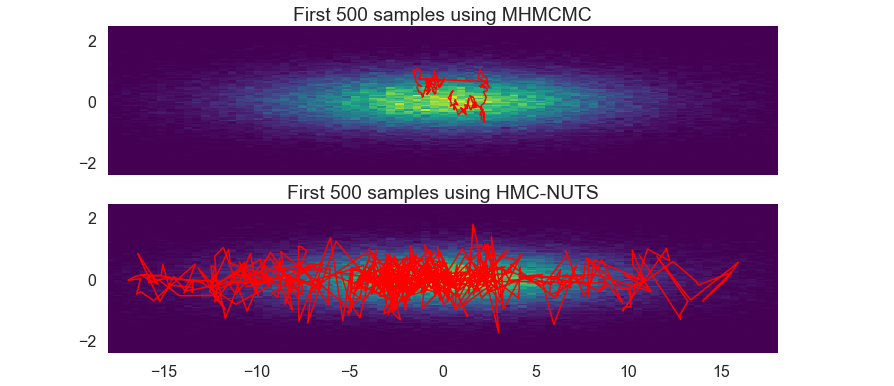

In [6]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.set_size_inches(12,6)
ax1.grid(False)
ax2.grid(False)
_ = ax1.hist2d(x=background_y[:,0], y=background_y[:,1], bins=100, cmap="viridis")
_ = ax1.set_xlim(-18, 18)
_ = ax1.plot(metr_y.transpose()[0,:], metr_y.transpose()[1,:],"r", lw=1.5)
_ = ax1.set_title("First 500 samples using MHMCMC")

_ = ax2.hist2d(x=background_y[:,0], y=background_y[:,1], bins=100, cmap="viridis")
_ = ax2.set_xlim(-18, 18)
_ = ax2.plot(nuts_y.transpose()[0,:], nuts_y.transpose()[1,:], "r", lw=1.5)
_ = ax2.set_title("First 500 samples using HMC-NUTS")
#f.suptitle("Sampling from a 50-d multivariate Gaussian with high covariance", fontsize=22, y=1)
f.savefig("50dim.jpg", dpi=500)


## Ring

Creating the data for the background image.

In [4]:
ring_model = pm.Model()
N = 100000
ndim = 2

try:
    with open("ring2dim100000_v3.pkl", "rb") as f:
        background_y = pickle.load(f)
except:
    with ring_model:
        mu = pm.Normal('mu', mu=0, sd=1, shape=(ndim), testval=0.1)
        mu_circle = pm.Deterministic("mu_circle", 5*(mu/np.sqrt((mu**2).sum())))
        y = pm.MvNormal('y', mu=mu_circle, cov=np.identity(ndim)/10, shape=(1,ndim))
        step = pm.NUTS([mu, y])
        trace = pm.sample(N, step=step, tune=1000)
    background_y = trace.get_values("y")

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, mu]
100%|█████████▉| 100594/101000 [17:25<00:05, 77.08it/s] /usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.713851771267, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 768 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 100991/101000 [17:28<00:00, 111.54it/s]/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.717492433487, but should be close to 0.8. Try to increase the number o

In [16]:
background_y = background_y.reshape(N, ndim)

Sampling from the distribution.

In [17]:
sample_N = 250

metr_ring_model = pm.Model()
nuts_ring_model = pm.Model()

with metr_ring_model:
    mu = pm.Normal('mu', mu=0, sd=1, shape=ndim, testval=0.1)
    mu_circle = pm.Deterministic("mu_circle", 5*(mu/np.sqrt((mu**2).sum())))
    y = pm.MvNormal('y', mu=mu_circle.flatten(), cov=np.identity(ndim)/10, shape=(ndim))
    step = pm.Metropolis(vars=[mu, y, mu_circle])
    trace = pm.sample(sample_N/2, step=step, tune=1000)
metr_ring_y = trace.get_values("y")
metr_ring_y = metr_ring_y.reshape(sample_N, ndim)

with nuts_ring_model:
    mu = pm.Normal('mu', mu=0, sd=1, shape=(ndim), testval=0.1)
    mu_circle = pm.Deterministic("mu_circle", 5*(mu/np.sqrt((mu**2).sum())))
    y = pm.MvNormal('y', mu=mu_circle, cov=np.identity(ndim)/10, shape=(ndim))
    step = pm.NUTS([mu, y])
    trace = pm.sample(sample_N/2, step=step, tune=1000)
nuts_ring_y = trace.get_values("y")
nuts_ring_y = nuts_ring_y.reshape(sample_N, ndim)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [y]
100%|██████████| 1125/1125.0 [00:01<00:00, 579.46it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, mu]
100%|█████████▉| 1123/1125.0 [00:17<00:00, 70.36it/s]/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:430: UserWarning: Chain 0 contains only 125 samples.
  % (self._chain_id, n))
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.690784422988, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1125/1125.0 [00:17<00:00, 62.81it/s]
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:430: UserWarning: Chain 1 contains only 125 samples.
  % (self._chain_id, n))


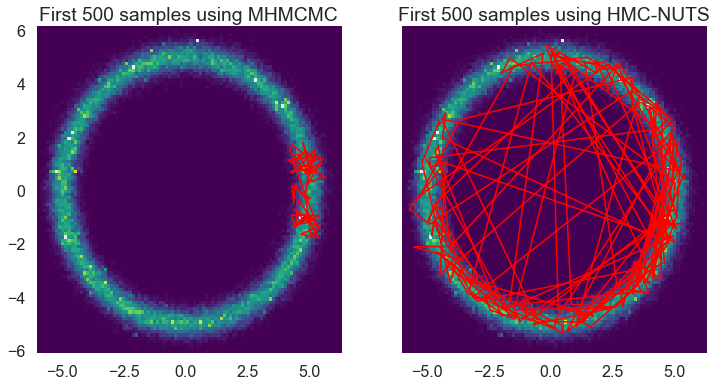

In [18]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)
f.set_size_inches(12,6)
ax1.grid(False)
ax2.grid(False)
_ = ax1.hist2d(x=background_y.transpose()[0,:], y=background_y.transpose()[1,:],bins=100, cmax=100, cmap="viridis")
_ = ax1.plot(metr_ring_y.transpose()[0,:], metr_ring_y.transpose()[1,:], "r", lw=1.5)
_ = ax1.set_title("First 500 samples using MHMCMC")

_ = ax2.hist2d(x=background_y.transpose()[0,:], y=background_y.transpose()[1,:],bins=100, cmax=100, cmap="viridis")
_ = ax2.plot(nuts_ring_y.transpose()[0,:], nuts_ring_y.transpose()[1,:], "r", lw=1.5)
_ = ax2.set_title("First 500 samples using HMC-NUTS")
#f.suptitle("Sampling from a 2-d annulus", fontsize=22, y=1)
f.savefig("ring.jpg", dpi=500)